<a href="https://colab.research.google.com/github/nicolas-pavon/Pose_Estimation_tf2/blob/master/Pose_Estimation_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Degree Project.

## Prediction methodology and relevance analysis based on deep learning

**Nicolás Pavón Gómez - Nacional de Colombia University**

### Goal
- Develop a data prediction methodology using deep learning through relevant representation, which allows the identification of predominant attributes in regression tasks.

## Pose Estimation with TensorFlow Colab Notebook.
### if you want to test it on your computer, go and follow the step by step on my GitHub repository:
- https://github.com/nicolas-pavon/Pose_Estimation_tf2



## Open Pose: Multi Person Pose Estimation.

Consider a core component in obtaining a detailed understanding of people in images and videos: human 2D pose estimation—or the problem of localizing anatomical keypoints or “parts”. 

Human estimation has largely focused on finding body parts of individuals. Inferring the pose of multiple people in images presents a unique set of challenges:

  - Each image may contain an unknown number of people that can appear at any position or scale.
  - Interactions between people induce complex spatial interference, due to contact, occlusion, or limb articulations, making association of parts difficult.
  - Runtime complexity tends to grow with the number of people in the image, making realtime performance a challenge.

## Multi Person Pose Estimation:
  - For multi-person pose estimation, most approaches have   used a top-down strategy that first detects people and then have estimated the pose of each person independently on each detected region.

#### COCO output Format:
- Nose $\to$ 0
- Neck $\to$ 1
- Right Shoulder $\to$ 2
- Right Elbow $\to$ 3
- Right Wrist $\to$ 4
- Left Shoulder $\to$ 5 
- Left Elbow $\to$ 6 
- Left Wrist $\to$ 7 
- Right Hip $\to$ 8
- Right Knee $\to$ 9 
- Right Ankle $\to$ 10 
- Left Hip $\to$ 11 
- Left Knee $\to$ 12
- Left Ankle $\to$ 13 
- Right Eye $\to$ 14 
- Left Eye $\to$ 15 
- Right Ear $\to$ 16
- Left Ear $\to$ 17 
- Background $\to$ 18

## Network Architecture:

<img src='https://www.learnopencv.com/wp-content/uploads/2018/05/openpose-body-architecture.png'>

  - $\textbf{Stage 0:}$ The first 10 layers of the VGGNet are used to create feature maps for the input image.

  - $\textbf{Stage 1:}$ A 2-branch multi-stage CNN is used where:
    - The first branch predicts a set of 2D Confidence Maps (S) of body part    locations. For example, the Confidence Map for the Left Shoulder is shown in figure below. It has high values at all locations where there is a left shoulder.

  <img src='https://www.learnopencv.com/wp-content/uploads/2018/05/confidence-left-shoulder.jpg'>

    - The second branch predicts a set of 2D vector fields (L) of Part Affinities (PAF), which encode the degree of association between parts (keypoints). Notice there is a large affinity between parts belonging to the same person show on the picture below.

  <img src='https://www.learnopencv.com/wp-content/uploads/2018/05/heatmap-left-shoulder.jpg'>

      $\textbf{The Confidence Maps are used to find the keypoints and the Affinity Maps are used to get the valid connections between the keypoints.}$

  - The system takes, as input, a color image of size $w \times h$ and produces the 2D locations of anatomical keypoints for each person in the image.

  In the model architecture:
    - $S\to$ Confidence Maps.
    - $L\to$ Vector Fields of Part Affinities has **$C$** vector fields, one per limb where $L_{c}\in\mathbb{R}^{w \times h \times 2} , c \in (1 \dots C)$
    - $S=(S_{1},S_{2},\dots,S_{j})\to$ Set of **$J$** confidence maps where $S_{j}\in\mathbb{R}^{w \times x}$
    - $t \in (1, \dots T) \to$ Stages

  - **Equations**:
    - *Detection and Association*
      \begin{equation} 
        L^{t} = \phi^{t}(F,L^{t-1}), \forall \leq t \leq T_{p} \tag{1}
      \end{equation}

      where $\phi^{t}$ refers to the CNNs for inferece on each Stage $t$, and $T_{P}$ to the numer of total **PAF** stages.

      \begin{equation} 
        S^{T_{P}} = \phi^{t}(F,L^{T_{P}}), \forall t = T_{P} \tag{2} 
      \end{equation}

      \begin{equation} 
        S^{t} = \phi^{t}(F,L^{T_{p}},S^{t-1}), \forall T_{P} < t \leq T_{P} + T_{C} \tag{3}
      \end{equation}

      where $p^{t}$ refers to the CNNs for inference at Stage, and $T_{C}$ to  the number of total confidence map stages.

      <img src='https://media.arxiv-vanity.com/render-output/3770521/x4.png'>*Stage 1*|*Stage 2*|*Stage 3*

      To guide the network to iteratively predict PAFs of body parts in the first branch and confidence maps in the second branch, it is use a loss function at the end of each stage. $L_{2}$ loss is use between the estimated predictions and the groundtruth maps and fields.

      \begin{equation} 
          f_{L}^{t_{i}} = \sum_{c=1}^{C} \sum_{p} W(p) \cdot \parallel L_{c}^{t_{i}}(p) - L_{c}^{*}(p) \parallel_2^2 \tag{4} 
      \end{equation}

      \begin{equation} 
          f_{S}^{t_{k}} = \sum_{j=1}^{J} \sum_{p} W(p) \cdot \parallel S_{j}^{t_{k}}(p) - S_{j}^{*}(p) \parallel_2^2 \tag{5} 
      \end{equation}

      where $L_{c}^{*}$ is the groundtruth part affinity vector field, is the groundtruth part confidence map. 

      $W$ is a binary mask $\therefore W(p)=0$ when the annotation is missing at an image location $p$. 

      The mask is used to avoid penalizing the true positive predictions during training. The intermediate supervision at each stage addresses the vanishing gradient problem by **replenishing the gradient periodically.**

      *Overall Objective*
      \begin{equation} 
          f = \sum_{t=1}^{T_{P}} f_{L}^{t} +  \sum_{t=T_{p}+1}^{T_{P}+T_{C}} f_{S}^{t} \tag{6} 
      \end{equation}

    - *Confidence maps for part detection*
    
      To evaluate in equation 6 during training, the groundtruth confidence maps are generated from the annotated keypoints 

      **Note:** if multiple people are in the image, there should be a peak corresponding to each visible part $j$ for each person $k$.

      First generate individual confidence maps $S_{j,k}^{\*}$ for each $k$ person. let $x_{j,k} \in \mathbb{R}^{2}$ be the groundtruth position of body part $j$ for each $k$ in the image, $S_{j,k}^{\*}$ is the valuea located at $p \in\mathbb{R}^{2}$ defined as:

      \begin{equation} 
          S_{j,k}^{*} = \exp(-\frac{\parallel p - x_{j,k} \parallel_{2}^{2}}{\sigma^2}) \tag{7}
      \end{equation}

      where $\phi$ controls the spread of the peak. Groundtruth confidence map predicted by the netwok via max operator is an aggregation of each individual confidence maps, as:

      \begin{equation} 
          S_{j}^{*} = \max(S_{j,k}^{*}(p)) \tag{8}
      \end{equation}

      <img src='https://media.arxiv-vanity.com/render-output/3770521/x5.png'>

    - *Part Affinity Fields for Part Association*

      <img src='https://cv-tricks.com/wp-content/uploads/2019/03/PAF.png'>

      Given a set of detected body parts(red and blue points in last figure) for assemble them to form the full-body poses uses a confidence measure of the association for each pair of body part detections.

      PAFs preserve both location and orientation information across the region of support on the limb(look at yellow arrows in the last picture)

      $\color{red}{x_{j_{1},k}} \to$ Part 1 (red point)
      
      $\color{blue}{x_{j_{2},k}} \to$ Part 2 (blue point)

      those points are the groundtruth positions of body.
      The value at $L_{c,k}^{\*}(p)$ is a unit vector thtat points from $j_{1} \to j_{2}$, to evaluate $f_l$ during training the groundtruth at an image point $p$ as
      \begin{equation}
        L_{c,k}^{*}(p) = 
        \begin{cases}
          v & \quad \text{p on limb c,k}\\
          0 & \quad \text{otherwise}
        \end{cases}
        \therefore
        v = \frac{x_{j_{2},k} - x_{j_{1},k}}{\parallel x_{j_{2},k} - x_{j_{1},k} \parallel_2} \tag{9}  \end{equation}

      $v$ is the unit vector on limb's direction. The set of points on the limb is defined as those whitin a distance threshold of the line segment, for example those $p$ points for wich:

      \begin{equation} 
          0 \leq v \cdot (0-x_{j_{1},k}) \leq l_{c,k} \space and \space | v_{\bot} \cdot (p-x_{j_{1},k})| \leq \sigma_l
      \end{equation}

      where,

      - $\sigma_l \to$ distance in pixels

      - $l_{c,k} = \parallel x_{j_{2},k} - x_{j_{1},k} \parallel_2 \to$ limb length

      - $v_\bot \to $ vector perpendicular to $v$

      - $L_{c}(p) \to$ Groundtruth part affinity field averages the affinity fields of all people in the image

      \begin{equation}
        L_{c}^{*} = \frac{1}{n_{c}(p)} \sum_k L_{c,k}^{*}(p) \tag{10}
      \end{equation}

      $n_{c}(p) \to $ non-zero vectors at point $p$ across all $k$

      The alignment of the predicted PAF is measure  with the candidate limb that would be formed by connecting body parts detected. Specifically, for two candidate part locations $d_{j,1}$ and $d_{j2}$ part affinity field $L_c$ predicted is sample along the line segment to meausure the confidence in their association:

      <img src='https://media.arxiv-vanity.com/render-output/3770521/x8.png'>

      \begin{equation}
        E = \int_{u=0}^{u=1}L_{c}(p(u)) \cdot \frac{d_{j2} - d_{j1}}{||d_{j2} - d_{j1}||_2} du \tag{11}
      \end{equation}

      $p(u) = (1-u)d_{j1} + ud_{j2}\to$ Interpolates the position of the two body parts $d_{j1}$ and $d_{j2}$

      **In practice, the integral is approximated by sampling and summing uniformly-spaced values of $u$.**
  
  - **Multi-Person Parsing using PAFs**

  Non-maximun suppression on the detection confidence maps must be perform to obtain the discrete set of part candidate locations.

  line integral is used to score each candidate limb on the PAF(Eq. 11), but there is a problem of finding the optimal parse corresponds to a $K$-dimensional matching problem knowing as NP-Hard(Part c in the last image)

  $\mathcal{D_{J}} = \{d_l^m: for \space j \in \{1 \ldots J\}, m \in \{1 \ldots N_j \}\} $

    - $\mathcal{D_{J}} \to $ Body part detection candidates set for multiple people on image.

    - $N_j \to$ Number of candidates of each $j$ part

    - $D_j^m \in \mathbb{R}^2 \to$ Location of the m-th detection candidate of $j$ (body part)

  $\mathcal{Z} = \{ z_{j_1j_2}^{mn}: for \space j_1,j_2 \in \{ 1 \ldots J \}, m  \in \{ 1\ldots N_{j_1} \}, n \in \{ 1 \ldots N_{j_2} \} \}$
    - $z_{j_1j_2}^{mn} \in 0,1 \to$ Indicate if two cadidate detection $d_{j_1}^{m}$ and $d_{j_2}^{n}$ are connect or not.

  \begin{equation}
      \text{max}_{Z_c} E_{c} = \text{max}_{Z_c} \sum_{m \in  \mathcal{D}_{j_1}} \sum_{n \in \mathcal{D}_{j_2}} E_{mn} \cdot z_{j_1j_2}^{mn}  \tag{12}
  \end{equation}
  
  \begin{equation}
      \forall m \in \mathcal{D}_{j_1}, \sum_{n \in \mathcal{D}_{j_2}} z_{j_1j_2}^{mn} \leq 1 \\
      \forall n \in \mathcal{D}_{j_2}, \sum_{m \in \mathcal{D}_{j_1}} z_{j_1j_2}^{mn} \leq 1 
  \end{equation}

  where,
    - $E_c \to$ Overall weight of the matching from limb type $c$

    - $Z_c \to$ Subset pf $Z$ for each type $c$ limb

    - $E_{mn} \to$ Part affinity between parts $d_{j_1}^{m}$ and $d_{j_2}^{n}$

  Equation 12 is optimizated as:
  \begin{equation}
      \text{max}_ZE = \sum_{c=1}^{C}\text{max}_{Z_{c}}E_{c}
  \end{equation}


  






  

  

  

#### 1. Clone and install dependencies.
Remember restart the runtime after install all dependencies.


In [ ]:
!git clone https://github.com/nicolas-pavon/Pose_Estimation_tf2.git
%cd Pose_Estimation_tf2
%mkdir results
!pip install -r requirements.txt

Cloning into 'Pose_Estimation_tf2'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 200 (delta 49), reused 63 (delta 22), pack-reused 97
Receiving objects: 100% (200/200), 114.78 MiB | 22.96 MiB/s, done.
Resolving deltas: 100% (61/61), done.
/content/Pose_Estimation_tf2
  Cloning https://github.com/adrianc-a/tf-slim.git (to revision remove_contrib) to /tmp/pip-req-build-7ar5gt45
  Running command git clone -q https://github.com/adrianc-a/tf-slim.git /tmp/pip-req-build-7ar5gt45
  Running command git checkout -b remove_contrib --track origin/remove_contrib
  Switched to a new branch 'remove_contrib'
  Branch 'remove_contrib' set up to track remote branch 'remove_contrib' from 'origin'.
Obtaining file:///content/Pose_Estimation_tf2 (from -r requirements.txt (line 17))
     |████████████████████████████████| 320.4MB 51kB/s 
     |████████████████████████████████| 81kB 6.2MB/s 
  Created

#### 2. Build c++ library for post processing

In [ ]:
%cd Pose_Estimation_tf2/tf_pose/pafprocess
!apt-get install swig 
!swig -python -c++ pafprocess.i && python setup.py build_ext --inplace
%cd ../..

/content/Pose_Estimation_tf2/tf_pose/pafprocess
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 11 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (1,126 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 144676 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpacking swig3.0 (3.0.12-1) ...
Selecting previously unselected package swig.
Preparing to

#### 3. if you want to download the CMU original model

In [ ]:
%cd models/graph/cmu
!bash download.sh
%cd ../../..

/content/Pose_Estimation_tf2/models/graph/cmu
[download] model graph : cmu
--2020-09-25 17:29:16--  http://download2182.mediafire.com/707r0g51sw7g/qlzzr20mpocnpa3/graph_opt.pb
Resolving download2182.mediafire.com (download2182.mediafire.com)... 199.91.154.176
Connecting to download2182.mediafire.com (download2182.mediafire.com)|199.91.154.176|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209299198 (200M) [application/octet-stream]
Saving to: ‘/content/Pose_Estimation_tf2/models/graph/cmu/graph_opt.pb’

/content/Pose_Estim 100%[===================>] 199.60M  11.1MB/s    in 18s     

2020-09-25 17:29:34 (11.0 MB/s) - ‘/content/Pose_Estimation_tf2/models/graph/cmu/graph_opt.pb’ saved [209299198/209299198]

[download] end
/content/Pose_Estimation_tf2


### Inference Test

In [ ]:
from tf_pose import common
import cv2
import numpy as np
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh
import time
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd
 
#Usefull functions
 
def select_image_size():
  while True:
    x = input(''' Select image size to use:
      1: 432x368
      2: 656x368
      3: 1312x736
      Choose 1 2 or 3:
    ''')
    x = int(x)
    if x==1 or x ==2 or x==3:
      break
 
  if x==1:
    w,h = 432,368
  elif x==2:
    w,h = 656,368
  else:
    w,h = 1312,736
  return w,h
 
def select_model():
  while True:
    m = input(''' Select model to use:
      1: mobilenet_thin
      2: mobilenet_v2_large
      3: mobilenet_v2_small
      4: cmu
      Choose 1 2 3 or 4:
    ''')
    m = int(m)
    if m==1 or m==2 or m==3 or m==4:
      break
      
  if m==1:
    model = 'mobilenet_thin'
  elif m==2:
    model = 'mobilenet_v2_large'
  elif m==3:
    model = 'mobilenet_v2_small'
  else:
    model = 'cmu'
  return model

 Select image size to use:
      1: 432x368
      2: 656x368
      3: 1312x736
      Choose 1 2 or 3:
    1
 Select model to use:
      1: mobilenet_thin
      2: mobilenet_v2_large
      3: mobilenet_v2_small
      4: cmu
      Choose 1 2 3 or 4:
    1


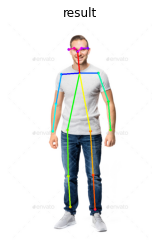

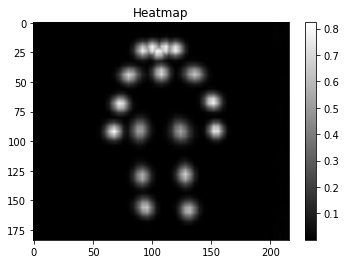

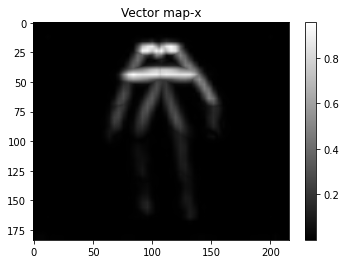

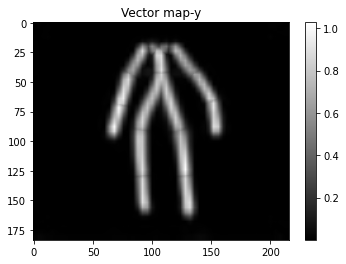

In [ ]:
w, h = select_image_size()
model = select_model()
 
e_s = TfPoseEstimator(get_graph_path(model), target_size=(w, h))
 
# estimate human poses from a single image !
image = common.read_imgfile('images/person.jpg', None, None)
if image is None:
  print('Image can not be read')
 
t = time.time()
humans = e_s.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)
elapsed = time.time() - t
 
image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)
 
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('result')
plt.axis('off')
plt.savefig('results/result.pdf', format='pdf', dpi=300)
plt.show()
 
bgimg = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2RGB)
bgimg = cv2.resize(bgimg, (e_s.heatMat.shape[1], e_s.heatMat.shape[0]), interpolation=cv2.INTER_AREA)
 
# show network output
tmp = np.amax(e_s.heatMat[:, :, :-1], axis=2)
plt.imshow(tmp, cmap=plt.cm.gray)
plt.title('Heatmap')
plt.colorbar()
plt.savefig('results/heatmap.pdf', format='pdf', dpi=300)
plt.show()
 
tmp2 = e_s.pafMat.transpose((2, 0, 1))
tmp2_odd = np.amax(np.absolute(tmp2[::2, :, :]), axis=0)
tmp2_even = np.amax(np.absolute(tmp2[1::2, :, :]), axis=0)
 
 
plt.imshow(tmp2_odd, cmap=plt.cm.gray)
plt.title('Vector map-x')
plt.colorbar()
plt.savefig('results/vectorx.pdf', format='pdf', dpi=300)
plt.show()
 
 
plt.imshow(tmp2_even, cmap=plt.cm.gray)
plt.title('Vector map-y')
plt.colorbar()
plt.savefig('results/vectory.pdf', format='pdf', dpi=300)
plt.show()

#### Save heatMat points (image)

In [ ]:
x_i = np.zeros(e_s.heatMat.shape[2]-1)
y_i = np.zeros(e_s.heatMat.shape[2]-1)
value_i = np.zeros(e_s.heatMat.shape[2]-1)
for i in range(e_s.heatMat.shape[2]-1):
  value_i[i] = np.amax(e_s.heatMat[:,:,i])
  x_i[i] = np.where(e_s.heatMat == value_i[i])[1]
  y_i[i] = np.where(e_s.heatMat == value_i[i])[0]

points_d = {}
points_d['Body_part'] = value_i
points_d['pos_x'] = x_i
points_d['pos_y'] = y_i


In [ ]:
body_points = pd.DataFrame(points_d)
body_points.to_csv('results/Body_points.csv',index=False)
body_points

,Body_part,pos_x,pos_y
0,0.809451,104.0,24.0
1,0.690797,108.0,44.0
2,0.685761,80.0,44.0
3,0.767096,72.0,68.0
4,0.823619,68.0,92.0
5,0.640379,136.0,44.0
6,0.782686,152.0,68.0
7,0.729826,152.0,92.0
8,0.504239,88.0,92.0
9,0.562622,92.0,128.0


### 4. Pose Estimation 

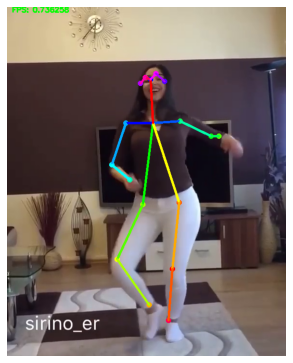

In [ ]:
w, h = select_image_size()
model = select_model()
print(model)
fps_time = 0
e = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False, show=False)
cam = cv2.VideoCapture('videos/sample1.mp4')
ret_val, image = cam.read()
 
#Save video
width = int(cam.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cam.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cam.get(cv2.CAP_PROP_FPS))
out = cv2.VideoWriter('results/output_video_colab.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
heatMat = []
while True:
  ret_val, image = cam.read()
  try:
    if image.all()==None:
      break
  except:
    if image==None:
      break
 
 
  humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)
  image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)
 
 
  
  cv2.putText(image,
              "FPS: %f" % (1.0 / (time.time() - fps_time)),
              (10, 10),  cv2.FONT_HERSHEY_SIMPLEX, 0.5,
              (0, 255, 0), 2)
  
 
  out.write(image) 
  plt.figure(figsize=(5,7))
  plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
  plt.axis('off')
  clear_output(wait=True)
  plt.show()
  fps_time = time.time()
  heatMat.append(e.heatMat)

cv2.destroyAllWindows
out.release()

#### Save heatMat points (video)

In [ ]:
heatMat = np.array(heatMat)
print(heatMat.shape)
frames = {}
for j in range(150):
  frame = []
  if j == 14:
    new = heatMat[15,:,:,:]
  elif j == 80:
    new = heatMat[81,:,:,:]
  else:
    new = heatMat[j,:,:,:]
  x_v = np.zeros(new.shape[2]-1)
  y_v = np.zeros(new.shape[2]-1)
  value_v = np.zeros(new.shape[2]-1)
  for i in range(new.shape[2]-1):
    value_v[i] = np.amax(new[:,:,i])
    x_v[i] = np.where(new == value_v[i])[1]
    y_v[i] = np.where(new == value_v[i])[0]

  frame.append(value_v)
  frame.append(x_v)
  frame.append(y_v)
  frame = np.array(frame).flatten()
  frames['Frame_' + str(j+1)] = frame


(150, 184, 216, 19)


In [ ]:
pd_frames = pd.DataFrame(frames)
pd_frames.to_csv('results/frames.csv',index=False)
pd_frames

,Frame_1,Frame_2,Frame_3,Frame_4,Frame_5,Frame_6,Frame_7,Frame_8,Frame_9,Frame_10,Frame_11,Frame_12,Frame_13,Frame_14,Frame_15,Frame_16,Frame_17,Frame_18,Frame_19,Frame_20,Frame_21,Frame_22,Frame_23,Frame_24,Frame_25,Frame_26,Frame_27,Frame_28,Frame_29,Frame_30,Frame_31,Frame_32,Frame_33,Frame_34,Frame_35,Frame_36,Frame_37,Frame_38,Frame_39,Frame_40,...,Frame_111,Frame_112,Frame_113,Frame_114,Frame_115,Frame_116,Frame_117,Frame_118,Frame_119,Frame_120,Frame_121,Frame_122,Frame_123,Frame_124,Frame_125,Frame_126,Frame_127,Frame_128,Frame_129,Frame_130,Frame_131,Frame_132,Frame_133,Frame_134,Frame_135,Frame_136,Frame_137,Frame_138,Frame_139,Frame_140,Frame_141,Frame_142,Frame_143,Frame_144,Frame_145,Frame_146,Frame_147,Frame_148,Frame_149,Frame_150
0,0.718872,0.706183,0.763442,0.725125,0.699635,0.788256,0.797187,0.699458,0.779285,0.746294,0.687165,0.784340,0.837934,0.863029,0.822045,0.822045,0.845314,0.851419,0.837254,0.863813,0.843182,0.841665,0.864743,0.838820,0.783527,0.844263,0.804274,0.871389,0.788666,0.780590,0.784894,0.865208,0.845980,0.850973,0.802562,0.806547,0.837498,0.777941,0.721702,0.723417,...,0.641040,0.656614,0.627910,0.563518,0.625045,0.658307,0.657728,0.558547,0.606211,0.757397,0.731587,0.698564,0.744866,0.776478,0.776461,0.744640,0.720705,0.692688,0.715899,0.777958,0.840809,0.768648,0.829984,0.769747,0.848391,0.778003,0.727504,0.781246,0.775643,0.757406,0.805441,0.760370,0.745299,0.814396,0.797795,0.803901,0.794111,0.841024,0.793262,0.809477
1,0.668779,0.720812,0.708970,0.662440,0.684272,0.709520,0.728780,0.729615,0.707877,0.730790,0.776557,0.806641,0.801185,0.775579,0.783845,0.783845,0.815750,0.838799,0.822521,0.797928,0.782478,0.788693,0.785606,0.766126,0.784145,0.793160,0.742892,0.718147,0.787250,0.801521,0.825200,0.807071,0.799094,0.806877,0.788200,0.745696,0.701877,0.737759,0.782589,0.785000,...,0.639082,0.649511,0.671228,0.680459,0.672164,0.690613,0.671250,0.649253,0.657822,0.693797,0.738517,0.693074,0.719078,0.706238,0.642979,0.669797,0.667710,0.638353,0.690823,0.687769,0.719469,0.725034,0.758898,0.756008,0.712637,0.686646,0.689326,0.729426,0.741037,0.728448,0.692338,0.736168,0.700164,0.711438,0.712974,0.737937,0.699172,0.720553,0.738052,0.740752
2,0.598828,0.666395,0.593516,0.592031,0.710574,0.670904,0.665362,0.727512,0.672413,0.675117,0.713287,0.731568,0.737004,0.723993,0.765198,0.765198,0.777758,0.734615,0.699336,0.693125,0.685846,0.638547,0.639525,0.630204,0.611217,0.646971,0.664862,0.715955,0.735807,0.737424,0.729059,0.708415,0.726831,0.749149,0.716267,0.722272,0.704989,0.736399,0.714107,0.720719,...,0.599599,0.664413,0.669143,0.613143,0.613887,0.625572,0.569546,0.594893,0.632296,0.686033,0.622589,0.557412,0.605664,0.661696,0.639620,0.660671,0.638767,0.551037,0.636279,0.626414,0.649917,0.613234,0.602585,0.519490,0.458962,0.447426,0.505965,0.489859,0.574506,0.645676,0.584554,0.640572,0.634239,0.631061,0.694083,0.669325,0.640900,0.696890,0.687656,0.713538
3,0.280286,0.278950,0.167998,0.310674,0.271763,0.426647,0.638410,0.663903,0.666045,0.594280,0.612991,0.588485,0.412223,0.585457,0.702018,0.702018,0.718348,0.716669,0.748304,0.639068,0.535941,0.316360,0.203807,0.296525,0.264894,0.243103,0.341154,0.635013,0.665846,0.656135,0.629505,0.522046,0.502943,0.541687,0.696047,0.726000,0.750048,0.793987,0.723399,0.741845,...,0.648391,0.604742,0.687528,0.637508,0.611012,0.645692,0.531677,0.454456,0.416059,0.170137,0.326337,0.271086,0.510808,0.727067,0.653624,0.668443,0.657346,0.200576,0.735362,0.708358,0.667749,0.624517,0.431248,0.370182,0.468156,0.494832,0.526358,0.211542,0.187873,0.253238,0.146017,0.445306,0.469505,0.591839,0.680975,0.573531,0.520949,0.505131,0.567842,0.752078
4,0.480213,0.567178,0.524262,0.427850,0.538787,0.412506,0.619419,0.527461,0.480139,0.473004,0.553842,0.312799,0.378488,0.534917,0.711784,0.711784,0.694914,0.650581,0.530050,0.513350,0.334477,0.106255,0.351321,0.232033,0.231026,0.185591,0.164626,0.383135,0.411147,0.356031,0.588616,0.427658,0.308728,0.566867,0.664441,0.751986,0.696598,0.726

In [ ]:
# download results
from google.colab import files
from datetime import date, datetime
import shutil

namefile = 'Pose_Estimation_Results__' + str(datetime.now().strftime("%Y_%m_%d_%H_%M_%d"))
shutil.make_archive(namefile, 'zip', 'results')
files.download(namefile+'.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###  Bonus: to read and show the body parts detected.

#### Image

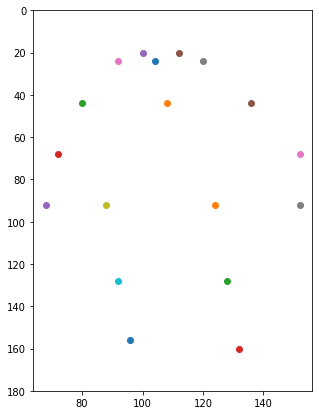

In [ ]:
body_points = pd.read_csv('results/Body_points.csv')
points = body_points.to_numpy()
x = points[:,1]
y = points[:,2]
plt.figure(figsize=(5,7))
for i in range(18):
  plt.scatter(x[i],y[i])
  plt.ylim(max(y)+20,min(y)-20)
plt.show()

#### Video

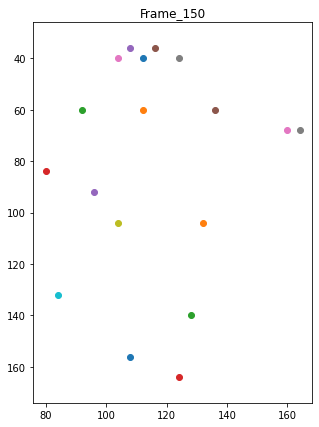

In [ ]:
body_points_frame = pd.read_csv('results/frames.csv')
points_frame = body_points_frame.to_numpy()
for j in range(points_frame.shape[1]):
  points_v = points_frame[:,j].reshape(3,e.heatMat.shape[2]-1)
  x_v = points_v[1,:]
  y_v = points_v[2,:]
  plt.figure(figsize=(5,7))
  for i in range(18):
    plt.scatter(x_v[i],y_v[i])
    plt.ylim(max(y_v)+10,min(y_v)-10)
  plt.title('Frame_'+str(j+1))
  clear_output(wait=True)
  plt.show()

# Trained Models & Performances

## Models
- cmu
  - the model based VGG pretrained network which described in the [original](https://github.com/CMU-Perceptual-Computing-Lab/openpose) paper.
  - [Ildoonet](https://github.com/ildoonet/tf-pose-estimation) converted Weights in Caffe format to use in tensorflow.

- dsconv
  - Same architecture as the cmu version except for the **depthwise separable convolution** of mobilenet.
  - Ildoonet trained it using 'transfer learning', but it provides not-enough speed and accuracy.

- mobilenet
  - Based on the mobilenet paper, 12 convolutional layers are used as feature-extraction layers.
- mobilenet v2
  - Similar to mobilenet, but using improved version of it.

| Name                 | Feature Layers      | Configuration                   |
|----------------------|---------------------|---------------------------------|
| cmu                  | VGG16               | OpenPose                        |
| mobilenet_thin       | Mobilenet           | width=0.75 refine-width=0.75    |
| mobilenet_v2_large   | Mobilenet v2 (582M) | width=1.40 refine-width=1.00    |
| mobilenet_v2_small   | Mobilenet v2 (97M)  | width=0.50 refine-width=0.50    |

## Performance on COCO Datasets

| Set         | Model               | Scale | Resolution | AP         | AP 50      | AP 75      | AP medium  | AP large   | AR         | AR 50      | AR 75      | AR medium  | AR large   |
|-------------|---------------------|-------|------------|------------|------------|------------|------------|------------|------------|------------|------------|------------|------------|
| 2014 Val    | Original Paper      | 3     | Image      |      0.584 |      0.815 |      0.626 |      0.544 |      0.651 |            |            |            |            |            |
| | | | | | | | | | | | | |
| 2014 Val    | CMU(openpose)       | 1     | Image      |     0.5067 |     0.7660 |     0.5377 |     0.4927 |     0.5309 |     0.5614 |     0.7900 |     0.5903 |     0.5089 |     0.6347 |
| 2014 Val    | VGG(openpose, Ildoonet)  | 1     | Image      |     0.5067 |     0.7660 |     0.5377 |     0.4927 |     0.5309 |     0.5614 |     0.7900 |     0.5903 |     0.5089 |     0.6347 |
| 2017 Val    | VGG(openpose, Ildoonet)  | 1     | Image      |     0.496  |     0.759  |     0.521  |     0.493  |     0.497  |     0.562  |     0.7830 |     0.590  |     0.506  |     0.644  |
| | | | | | | | | | | | | |
| 2014 Val    | Mobilenet thin      | 1     | Image      |     0.2806 |     0.5577 |     0.2474 |     0.2802 |     0.2843 |     0.3214 |     0.5840 |     0.2997 |     0.2946 |     0.3587 |
| 2014 Val    | Mobilenet-v2 Large  | 1     | Image      |     0.3130 |     0.5846 |     0.2940 |     0.2622 |     0.3850 |     0.3680 |     0.6101 |     0.3637 |     0.2765 |     0.4912 |
| 2014 Val    | Mobilenet-v2 Small  | 1     | Image      |     0.1730 |     0.4062 |     0.1240 |     0.1501 |     0.2105 |     0.2207 |     0.4505 |     0.1876 |     0.1601 |     0.3020 |


## Computation Budget & Latency

| Model               | mAP@COCO2014 | GFLOPs | Latency(432x368)<br/>(Macbook 15' 2.9GHz i9, tf 1.12) | Latency(432x368)<br/>(V100 GPU) | Latency(432x368)<br/>Intel core i5-8300H 2.3Ghz on tf 2.3<br/>GPU Nvidia GTX 1050 4GB | Google Colaboratory with GPU
|---------------------|-------------:|--------|------------------------------------------------------:|-------------------------------:|-------------:|------------:|
| CMU, VGG(OpenPose)  |              |        | 0.8589s | 0.0570s | 4 FPS | 10 FPS |
| Mobilenet thin      | 0.2806       |        | 0.1701s | 0.0217s | 20 FPS | 28 FPS |
| Mobilenet-v2 Large  | 0.3130       |        | 0.2066s | 0.0214s | 15 FPS | 30 FPS|
| Mobilenet-v2 Small  | 0.1730       |        | 0.1290s | 0.0210s | 25 FPS | 35 FPS |



In [ ]:
heatMat_new = heatMat_new.to_numpy().reshape(e.heatMat.shape[0],e.heatMat.shape[1],heatMat_new.shape[1])
for i in range(heatMat_new.shape[2]):
  plt.imshow(heatMat_new[:, :, i], cmap=plt.cm.gray)
  plt.title('frame '+str(i+1))
  plt.colorbar()
  plt.show()

In [ ]:
import pandas as pd
frame = {}
x = np.array(x)
for i in range(x.shape[0]):
  z = x[i,:,:].flatten()
  frame['Frame_' + str(i+1)] = z
frame_pd = pd.DataFrame(frame)
frame_pd.to_csv('results/frames.csv',index=False)